In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division

In [2]:
def readMODELnc(filename, var):
    """ 
    Read a variable from a NEMO output (netcdf 3 or 4)
    """

    f = netcdf.netcdf_file(filename, 'r')
    data = f.variables[var].data
    f.close()

    return data



## Extract the thermocline depth (depth of the 13C isotherm) for the 4 Celtic sea moorings ##

In [3]:
list_mooring = ['ST1','ST2','ST4','ST5']

depth_thermocline_mod = np.zeros((790,4))
depth_thermocline_obs =  np.zeros((790,4))
print(depth_thermocline_mod.shape)
Tlen = 790

count = 0
for numb in list_mooring:
    print(numb)
    filename = '/media/karen/data1/AMM60/FASTNEt/AMM60/mooring_' + numb +'.nc'
    temp_obs = readMODELnc(filename,'temp_obs')
    temp_mod = readMODELnc(filename,'temp_mod')
    depth = readMODELnc(filename,'depth')
    temp_mod_noNaN = np.zeros((temp_mod.shape[0]-1,temp_mod.shape[1]))
    temp_obs_noNaN = np.zeros((temp_mod.shape[0]-1,temp_mod.shape[1]))
    for ii in range(0,temp_mod.shape[0]):
        x = temp_mod[ii,:]
        mask = np.isfinite(x)
        xi = np.arange(len(x))
        if mask.sum() != 0:
            xfiltered = np.interp(xi, xi[mask], x[mask])
            temp_mod_noNaN[ii,:] = xfiltered
            x = temp_obs[ii,:]
            mask = np.isfinite(x)
            xi = np.arange(len(x))
            xfiltered = np.interp(xi, xi[mask], x[mask])
            temp_obs_noNaN[ii,:] = xfiltered

    depth_thermocline_mod[:,count] = depth[np.argmin(abs(temp_mod_noNaN-13),axis=0)]
    depth_thermocline_obs[:,count] = depth[np.argmin(abs(temp_obs_noNaN-13),axis=0)]
    count += 1



(790, 4)
ST1
ST2
ST4
ST5


/home/karen/anaconda2/lib/python2.7/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


## FFT ##

source https://fr.mathworks.com/matlabcentral/answers/64114-fft-code-on-time-series

( + use of a hanning filter to smooth the data)



In [23]:


Fs = np.divide(1.,3600.) # 1 cycle per hour, so every 3600 sec.
L = Tlen
N = np.ceil(np.log2(L))
f = np.multiply(Fs/np.power(2,N),range(0,int(np.power(2,N-1)-1)))

win_hanning = np.hanning(L)
inv_hanning = np.sqrt(np.sum(np.square(win_hanning[:np.floor(L/2)],win_hanning[:np.floor(L/2)])))

fftamm60 = np.zeros((511,4))
fftobsamm60 = np.zeros((511,4))
for xx in range(0,4):
    mod_norm = np.divide(np.multiply(win_hanning,depth_thermocline_mod[:,xx]),inv_hanning)
    obs_norm = np.divide(np.multiply(win_hanning,depth_thermocline_obs[:,xx]),inv_hanning)
    FFTmod = np.fft.fft(mod_norm,int(np.power(2,N)))
    fft_real_mod_amm60 = np.multiply(FFTmod,np.conj(FFTmod))

    FFTobs = np.fft.fft(obs_norm,int(np.power(2,N)))
    fft_real_obs_amm60 = np.multiply(FFTobs,np.conj(FFTobs))
    famm60 = f
    fftamm60[:,xx] = fft_real_mod_amm60[0:int(np.power(2,N-1)-1)]
    fftobsamm60[:,xx] = fft_real_obs_amm60[0:int(np.power(2,N-1)-1)]



/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
/home/karen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part


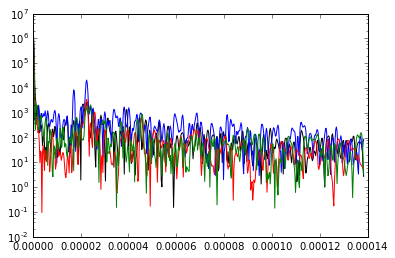

In [26]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
%matplotlib inline
plt.semilogy(famm60,fftobsamm60[:,0],color='k')
plt.hold()
plt.semilogy(famm60,fftobsamm60[:,1],color='b')
plt.semilogy(famm60,fftobsamm60[:,2],color='r')
plt.semilogy(famm60,fftobsamm60[:,3],color='g')



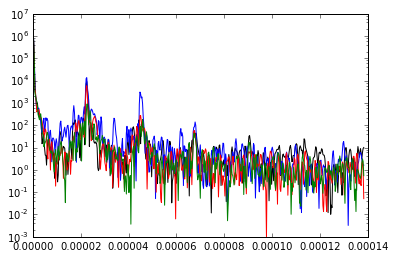

In [28]:
plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
%matplotlib inline
plt.semilogy(famm60,fftamm60[:,0],color='k')
plt.hold()
plt.semilogy(famm60,fftamm60[:,1],color='b')
plt.semilogy(famm60,fftamm60[:,2],color='r')
plt.semilogy(famm60,fftamm60[:,3],color='g')

